In [2]:
import pandas as pd
import json
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report


In [3]:
with open('../config.json', 'r') as file:
    config = json.load(file)

In [4]:
df = pd.read_csv(config['cleaned_supervised']+ '/supervised_data.csv.gz')

In [5]:
def extract_dps_one(x):
    return eval(x)[0]
def extract_dps_two(x):
    return eval(x)[1]
def extract_dps_three(x):
    try:
        return eval(x)[2]
    except:
        return 0


In [6]:
df['DpsOne']=df['DpsClass'].apply(extract_dps_one)

In [7]:
df['DpsTwo']=df['DpsClass'].apply(extract_dps_two)

In [8]:
df['DpsThree']=df['DpsClass'].apply(extract_dps_three)

In [10]:
dps_mapping = {
    'hunter':1,
    'demon-hunter':2,
    'evoker':3,
    'mage':4,
    'druid':5,
    'paladin':6,
    'death-knight':7,
    'monk':8,
    'priest':9,
    'rogue':10,
    'shaman':11,
    'warlock':12,
    'warrior':13,
    0:0
}


In [11]:
df['DpsOne'] = df['DpsOne'].map(dps_mapping)

In [12]:
df['DpsTwo'] = df['DpsTwo'].map(dps_mapping)

In [13]:
df['DpsThree'] = df['DpsThree'].map(dps_mapping)

In [14]:
tank_mapping = {
    'demon-hunter':6,
    'paladin':5,
    'death-knight':4,
    'druid':3,
    'monk':2,
    'warrior':1
}
df['TankClass'] = df['TankClass'].map(tank_mapping)

In [15]:
df['HealerClass'].unique()

array(['priest', 'druid', 'paladin', 'evoker', 'shaman', 'monk', nan],
      dtype=object)

In [16]:
healer_mapping = {
    'priest':6,
    'druid':5,
    'monk':4,
    'shaman':3,
    'evoker':2,
    'paladin':1,
    np.nan: 6
}
df['HealerClass'] = df['HealerClass'].map(healer_mapping)

In [17]:
dungeon_name_mapping = {
    "Algeth'ar Academy":8,
    "Ruby Life Pools":7,
    "Brackenhide Hollow":6,
    "The Nokhud Offensive":5,
    "Neltharus":4,
    "The Azure Vault":3,
    "Halls of Infusion":2,
    "Uldaman: Legacy of Tyr":1
}
df['dungeon.name'] = df['dungeon.name'].map(dungeon_name_mapping)

In [18]:
df = df.drop(['DpsClass'],axis=1)

In [19]:
df['Success'] = df['Success'].apply(lambda x : 1 if x else 0)

In [20]:
df.head()

,Success,TankClass,HealerClass,NumberOfDeaths,TotalTimeTaken,dungeon.name,DpsOne,DpsTwo,DpsThree
0,1,5,6,2,21.138500,2,2,1,12
1,1,6,5,4,19.361667,2,8,6,6
2,1,6,5,3,20.258850,8,1,8,6
3,1,5,5,1,24.897383,1,4,11,12
4,1,6,5,4,15.684633,7,2,3,4


In [21]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)



In [22]:
X_train = train_df[['TankClass', 'HealerClass', 'NumberOfDeaths','dungeon.name','DpsOne','DpsTwo','DpsThree']]
y_train = train_df['Success']
X_test = test_df[['TankClass', 'HealerClass', 'NumberOfDeaths','dungeon.name','DpsOne','DpsTwo','DpsThree']]
y_test = test_df['Success']

In [23]:
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10, 100],

        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 10, 20, 30, 40, 50],
        'classifier__min_samples_split': [2, 5, 10, 20],
        'classifier__min_samples_leaf': [1, 2, 4, 6, 8],
        'classifier__splitter': ['best', 'random'],
        'classifier__criterion': ['gini', 'entropy', 'log_loss']
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    }
}

In [24]:
classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=200)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('SVM', SVC()),
    ('KNN', KNeighborsClassifier())
]

In [25]:
target_names = ['Failure', 'Success']

In [26]:
results = {}

# Iterate over classifiers
for name, clf in classifiers:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standard scaler step
        ('classifier', clf)  # Classifier step
    ])

    # Perform GridSearchCV
    param_grid = param_grids[name]
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Predict on the test data with the best model
    y_pred = best_model.predict(X_test)

    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)

    # Get classification report
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    results[name] = report

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.64      0.71       512
           1       0.96      0.98      0.97      4436

    accuracy                           0.95      4948
   macro avg       0.87      0.81      0.84      4948
weighted avg       0.94      0.95      0.94      4948

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       512
           1       0.97      0.97      0.97      4436

    accuracy                           0.94      4948
   macro avg       0.84      0.83      0.84      4948
weighted avg       0.94      0.94      0.94      4948

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.61      0.70       512
           1       0.96      0.98      0.97      4436

    accuracy                           0.95      4948
   macro avg       0.89      0.80      0.84      4948
weigh

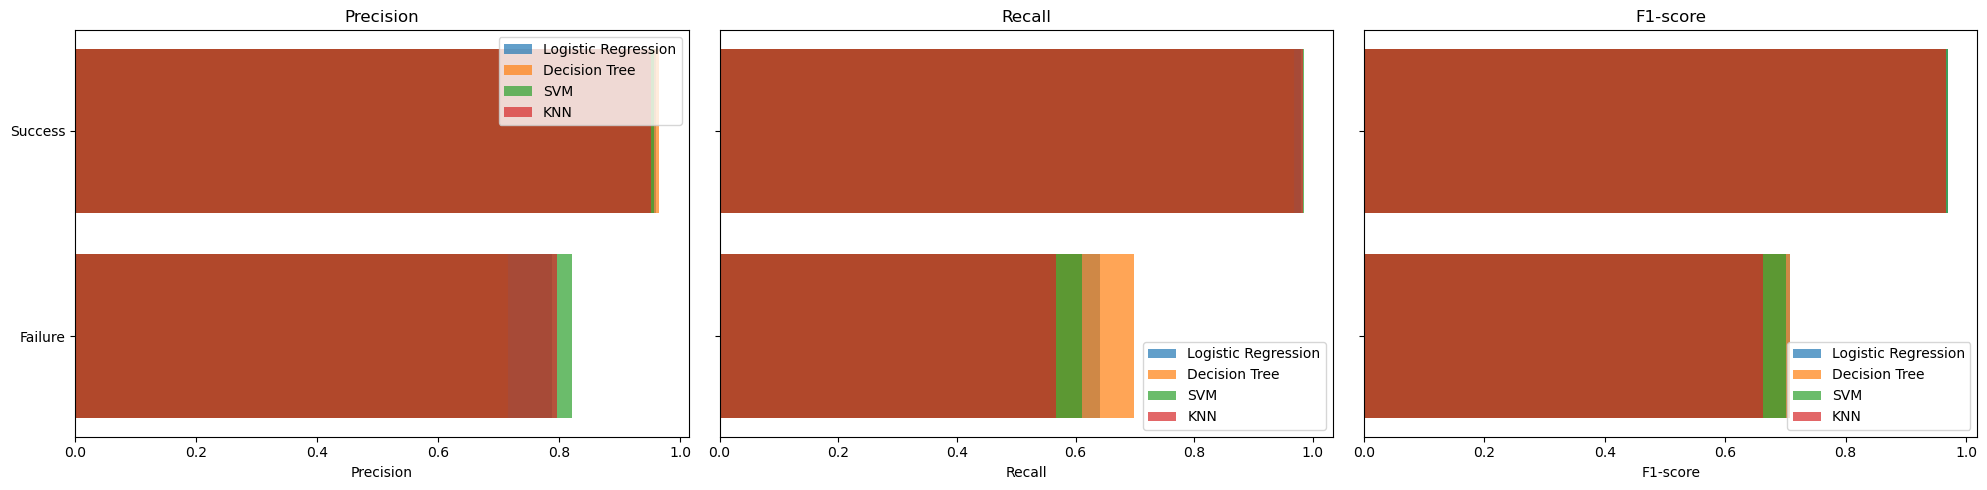

In [27]:
metrics = ['precision', 'recall', 'f1-score']

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    for clf_name, report in results.items():
        values = [report[class_name][metric] for class_name in target_names]
        ax.barh(target_names, values, label=clf_name, alpha=0.7)

    ax.set_title(metric.capitalize())
    ax.set_xlabel(metric.capitalize())
    ax.legend()

plt.tight_layout()
plt.show()